# Estimating air pollution in South Korea using China's air pollution data

Since a few years ago, air pollution in Korea is getting worse rapidly. Many Koreans say the main reason for this drastic surge of PM 2.5 and PM 10, which are microdust, is air pollution in China. They argue that microdust from China come over to Korea and it makes their air polluted. Some of them use the live-stream air pollution map as evidence. However, the Chinese strongly disagree with that idea. I want to figure out which is true. 

If it is possible to predict Korea's air pollution using China's air pollution data, it could be proof that China's air pollution somewhat affects Korea's air pollution. I am going to use hourly PM 2.5 data for both countries from January 2015 to June 2017, 21,888 data total. 
I am going to use the LSTM. To estimate Korea's PM 2.5 at time t, time period t-72 to t-1 China's and Korea's PM 2.5 are used. After that, I am going to compare the result with the model that only use Korea's t-72 to t-1 as a dependent variable. If the first model works better than the other, it is hard to say China's air pollution do nothing to air in Korea's territory. If the result between the first and second model has no difference or if the second one works better, all of the microdust in Korea is produced in their country.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import sys

#Import Korea data and replace NA to mean of month.

path = 'C://Users//dan37//Desktop//pm2.5//Korea_Data'
all_files = glob.glob(os.path.join(path, '*'))
all_data = []
for file in all_files:
    data = pd.read_excel(file, index_col=None)
    all_data.append(data)
korea_n = []
for i in range(len(all_data)):
     a = all_data[i]['PM2.5'][1:]
     korea_n.append(a)

china = pd.read_csv('China_Final.csv')
korea = pd.read_csv('Korea_Final.csv')
k1 = pd.read_csv('C:\Users\dan37\Desktop\pm2.5\Korea Data\Korea_Final.xlsx')
means = []
for col in korea.columns:
    m = np.mean(korea[col])
    means.append(m)
means = np.round(means)
for i in range(len(all_files)):
    korea_n[i].fillna(means[i],inplace=True)
korea_final = np.concatenate(korea_n)
korea_final = np.int64(korea_final)

#Import China data and replace NA to month average.
path = 'C://Users//dan37//Desktop//pm2.5//China_Data'
all_files = glob.glob(os.path.join(path, '*'))
all_data = []
for data in all_files:
    c1 = pd.read_csv(data, index_col = None, encoding = "ISO-8859-1")
    c2 = c1['Value']
    all_data.append(c2)
#how many NA?
temp = np.concatenate(all_data)
t = 0
for i in range(len(temp)):
    if temp[i]==-999:
        t+=1
print('%f%% of data is missing' %(t/len(temp)*100))
#not a significant amount of data. I will replace NA to annual average since getting month average for this dataset is a lot of works.
for i in range(len(all_data)):
    mean = np.mean(all_data[i])
    for j in range(len(all_data[i])):
        if all_data[i][j]==-999:
            all_data[i][j]=mean

china_final = np.concatenate(all_data)

t = 0
for i in range(len(china_final)):
    if temp[i]==-999:
        t+=1
print(t)

#checking if korea_final has same length with china_final.
len(korea_final) == len(china_final)
#Looks good. lets explorer data.

sns.jointplot(korea_final, china_final)
#Both data are skewed. Hard to find any correlation from the plot. 
#Normalisation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
china_final = china_final.reshape(len(china_final),1)
scaled_c = scaler.fit_transform(china_final)
scaler = MinMaxScaler()
korea_final = korea_final.reshape(len(korea_final),1)
scaled_k = scaler.fit_transform(korea_final)
sns.distplot(scaled_k)

#Divide to train and test set.
train_c = scaled_c[:19800]
cv_c = scaled_c[19800:]
train_k = scaled_k[:19800]
cv_k = scaled_k[19800:]

X_temp = []
X2_temp = []
y_temp = []
for i in range(72, len(scaled_c)):
    X_temp.append(scaled_c[i-72:i, 0])
    y_temp.append(scaled_k[i, 0])
    X2_temp.append(scaled_k[i-72:i,0])

X_temp,X2_temp = np.array(X_temp), np.array(X2_temp)
y_temp = np.array(y_temp)
X_train,X2_train = X_temp[:19800],X2_temp[:19800]
X_CV, X2_CV = X_temp[19800:],X2_temp[19800:]
y_train = y_temp[:19800]
y_CV = y_temp[19800:]
#2D to 3D
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_CV = np.reshape(X_CV, (X_CV.shape[0], X_CV.shape[1], 1))
X2_train = np.reshape(X2_train, (X2_train.shape[0], X2_train.shape[1], 1))
X2_CV = np.reshape(X2_CV, (X2_CV.shape[0], X2_CV.shape[1], 1))
X_train_f = np.dstack((X_train,X2_train))
X_CV_f = np.dstack((X_CV,X2_CV))
y_train = np.reshape(y_train, (19800,1))


In [ ]:
#Model 1 (Using both Korea and China data as dependent variables)
Model1 = Sequential()
Model1.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 2)))
Model1.add(Dropout(0.1))
Model1.add(LSTM(units = 50, return_sequences = True))
Model1.add(Dropout(0.1))
Model1.add(LSTM(units = 50, return_sequences = True))
Model1.add(Dropout(0.1))
Model1.add(LSTM(units = 50))
Model1.add(Dropout(0.1))
Model1.add(Dense(units = 1))
Model1.compile(optimizer = 'adam', loss = 'mean_squared_error')
Model1.fit(X_train_f, y_train, epochs = 100, batch_size = 32)
y_pred1 = Model1.predict(X_CV_f)

plt.figure(figsize = (20,10))
plt.plot(y_train, color = 'red', label = 'Korea PM2.5')
plt.plot(Model1.predict(X_train_f), color = 'blue', label = 'Predicted Korea PM2.5')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

plt.figure(figsize = (20,10))
plt.plot(y_CV, color = 'red', label = 'Korea PM2.5')
plt.plot(y_pred3, color = 'blue', label = 'Predicted Korea PM2.5')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

y_CV = np.reshape(y_CV, (2016,1))
plt.plot(y_CV-y_pred1)

In [ ]:
#Model with JUST Korea (72 hours) for X

Model2 = Sequential()
Model2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
Model2.add(Dropout(0.1))
Model2.add(LSTM(units = 50, return_sequences = True))
Model2.add(Dropout(0.1))
Model2.add(LSTM(units = 50, return_sequences = True))
Model2.add(Dropout(0.1))
Model2.add(LSTM(units = 50))
Model2.add(Dropout(0.1))
Model2.add(Dense(units = 1))
Model2.compile(optimizer = 'adam', loss = 'mean_squared_error')
Model2.fit(X2_train, y_train, epochs = 100, batch_size = 32)
y_pred2 = Model2.predict(X2_CV)

plt.figure(figsize = (20,10))
plt.plot(y_train, color = 'red', label = 'Korea PM2.5')
plt.plot(Model2.predict(X2_train), color = 'blue', label = 'Predicted Korea PM2.5')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

plt.figure(figsize = (20,10))
plt.plot(y_CV, color = 'red', label = 'Korea PM2.5')
plt.plot(y_pred2, color = 'blue', label = 'Predicted Korea PM2.5')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

y_CV = np.reshape(y_CV, (2016,1))
plt.plot(y_CV-y_pred2)

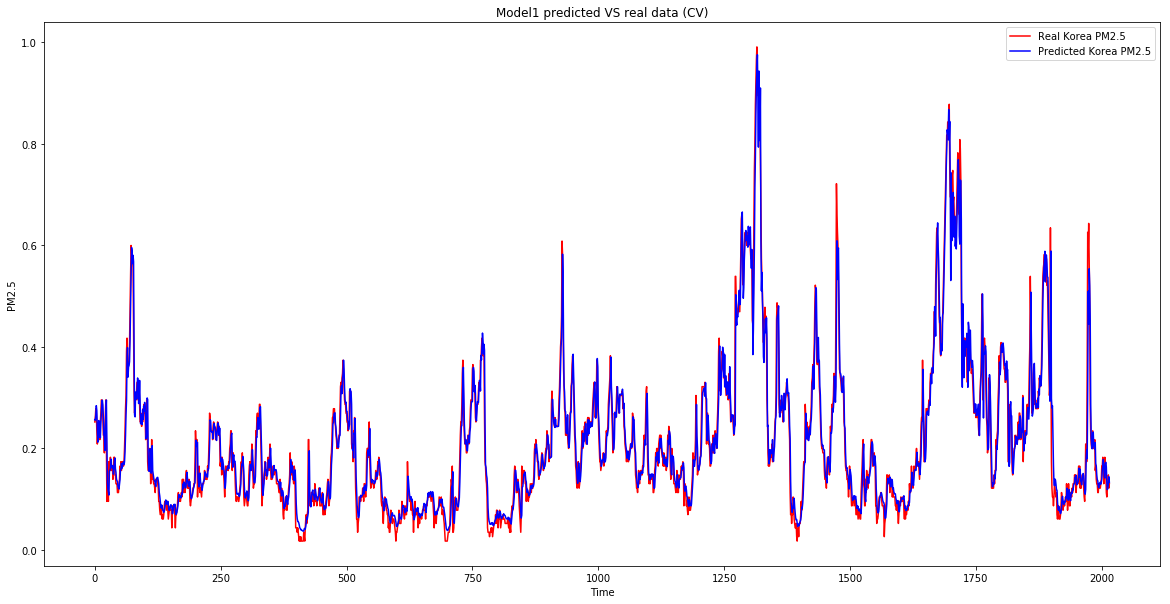

In [4]:
# Plot for model 1
from IPython.display import Image
img = 'FINAL 1-1.png'
Image(filename=img)


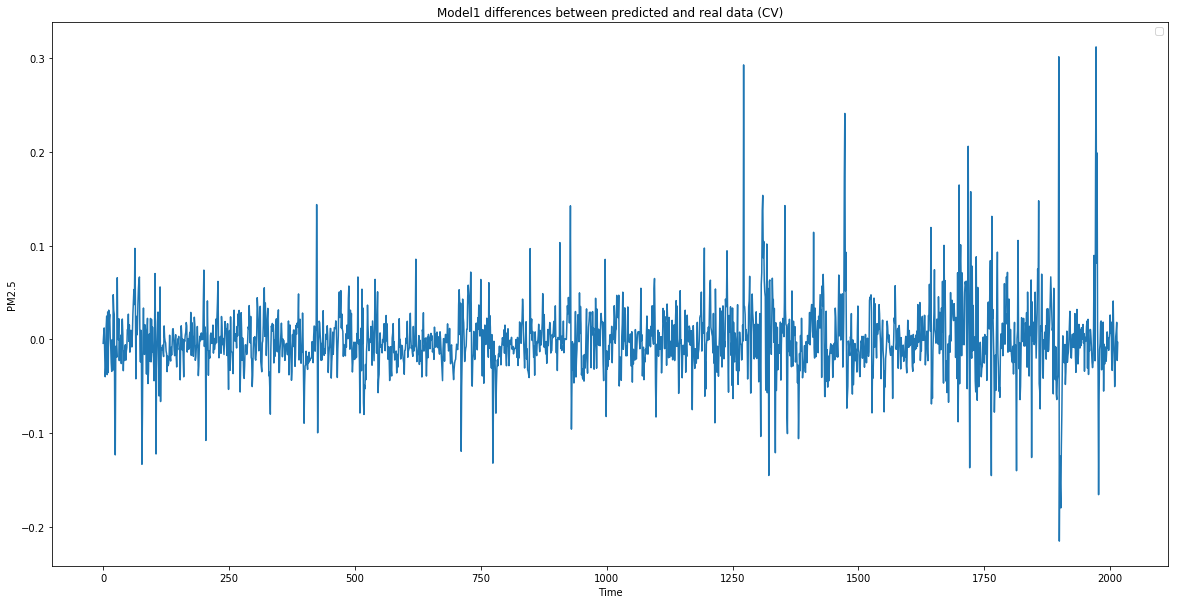

In [5]:
img = 'FINAL 1-2.png'
Image(filename=img)

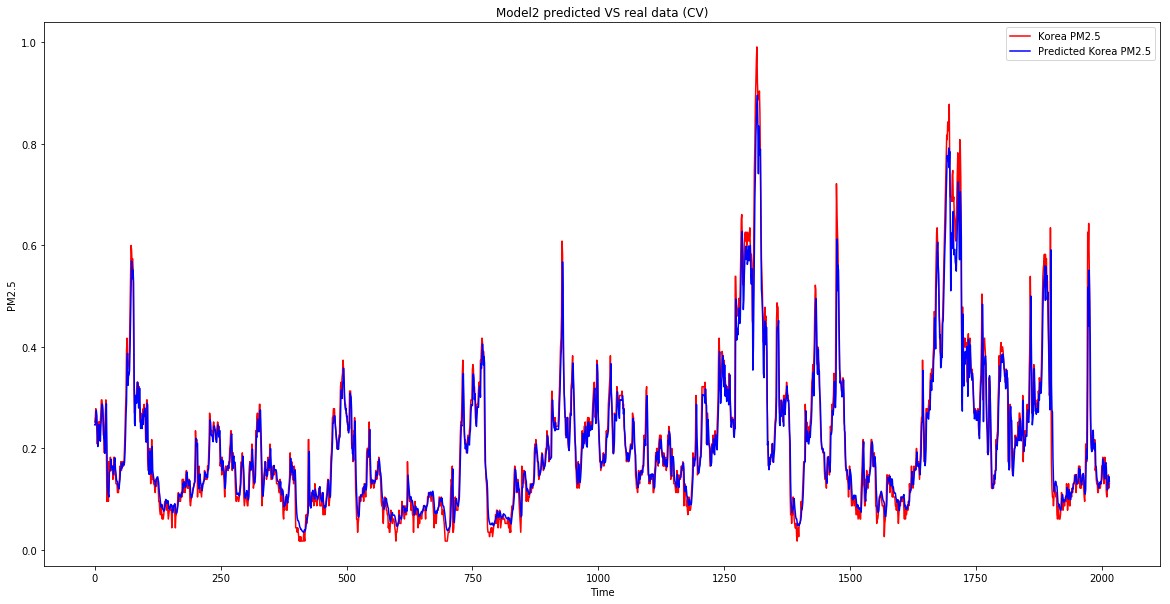

In [6]:
#Plot for Model 2
img = 'FINAL 2-1.png'
Image(filename=img)

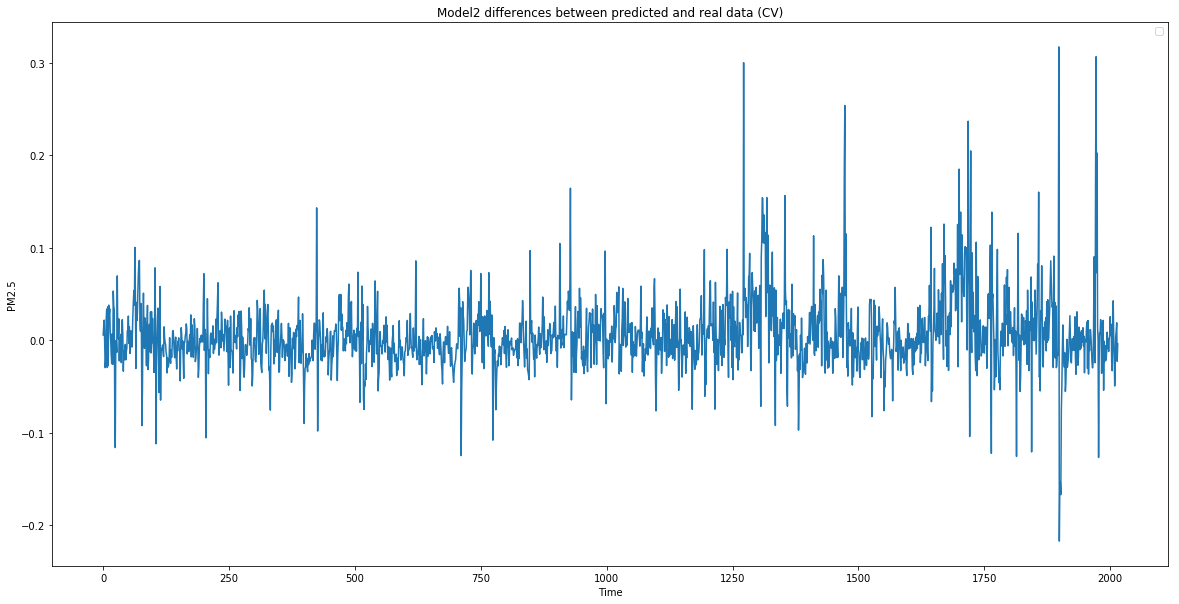

In [7]:
img = 'FINAL 2-2.png'
Image(filename=img)

As we can realize from the plots, there are no significant differences between the result of the two models. However, when we compare plot FINAL 1-1 and FINAL 2-1, we can see the Model 1 have a slightly better result than the another. But we can still estimate PM2.5 in the Korean territory's air pretty accurately just using Korea's past data.

My conclusion is, China's air pollution is definitely affecting Korea's air quality, however, it doesn't have a huge effect. It is just a conclusion from this model. I only use PM2.5 data since it's the only hourly data I can find in online. If I use other data, for example, PM10 or another air quality index, I might get a different result. Also, I use Beijing's PM2.5 data and Beijing is quite far away from Korea. If I pick a city in China where is closer to Korea than Beijing, I might get a different result.